## PSD estimates feature extraction using MNE library

### Multitaper

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,f1_score
from sklearn.decomposition import PCA
from spectrum import data_cosine, dpss, pmtm
from mne.time_frequency import psd_array_multitaper


%matplotlib inline 
# %matplotlib qt


In [2]:
# Import datasets, 0.1s samples
T_theta = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/theta/think.pkl")
T_alpha = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/alpha/think.pkl")

C_theta = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/theta/count.pkl")
C_alpha = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/alpha/count.pkl")


In [12]:
def psd_multitaper(df):
    psd_df = df.applymap(lambda x: psd_array_multitaper(x,128,adaptive=True,normalization='full',verbose=0)[0])
    return psd_df 

In [4]:
T_psd_theta = psd_multitaper(T_theta)
T_psd_alpha = psd_multitaper(T_alpha) 

In [5]:
C_psd_theta = psd_multitaper(C_theta)
C_psd_alpha = psd_multitaper(C_alpha) 

In [6]:
print(T_psd_theta.shape)
print(T_psd_alpha.shape)
print(C_psd_theta.shape)
print(C_psd_alpha.shape)

(320, 32)
(320, 32)
(320, 32)
(320, 32)


In [7]:
print(len(T_psd_theta.iloc[0,0]))
print(len(T_psd_alpha.iloc[0,0]))
print(len(C_psd_theta.iloc[0,0]))
print(len(C_psd_alpha.iloc[0,0]))

7
7
7
7


In [13]:
#Expand cells into columns
def expand_PSD_df_list(PSD_df_list):
    e_PSD_df_list = [0]*len(PSD_df_list)
    for df_no in range(len(PSD_df_list)):
        #e_PSD_df_cols_list will be used to create new dataframe
        no_PSD = len(PSD_df_list[0].iloc[0,0])
        e_PSD_df_cols_list = [0]*32
        
        for channel in range(len(PSD_df_list[df_no].columns)):
            #Expand each column into its own dataframe
            new_col = PSD_df_list[df_no][channel].apply(pd.Series)
            #Rename every variable in the new column
            new_col = new_col.rename(columns = lambda x: "Ch"+str(channel+1)+'_'+str(np.linspace(0,64,no_PSD)[x]))
            #Add new_col to cols_list
            e_PSD_df_cols_list[channel] = new_col
        
        #Create new dataframe
        e_PSD_df = pd.concat(e_PSD_df_cols_list, axis=1)
        
        #Add to list
        e_PSD_df_list[df_no] = e_PSD_df
    return e_PSD_df_list     

In [9]:
T_e_psd_theta = expand_PSD_df_list([T_psd_theta])[0]
T_e_psd_alpha = expand_PSD_df_list([T_psd_alpha])[0]
C_e_psd_theta = expand_PSD_df_list([C_psd_theta])[0]
C_e_psd_alpha = expand_PSD_df_list([C_psd_alpha])[0]


In [10]:
#Form datasets 
T_data = np.hstack((T_e_psd_theta,T_e_psd_alpha))
C_data = np.hstack((C_e_psd_theta,C_e_psd_alpha))

print(T_data.shape)
print(C_data.shape)

(320, 448)
(320, 448)


In [11]:
X = np.vstack((T_data,C_data))
y = np.hstack((np.array(['T']*T_data.shape[0]),
               np.array(['C']*C_data.shape[0]),
               ))

X.shape

(640, 448)

In [12]:
#Feature scaling 
sc = StandardScaler()
X = sc.fit_transform(X)
print(X.shape)
print(y.shape)

(640, 448)
(640,)


In [13]:
#Save datasets 
np.save("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/featureScaled/X-features",X,allow_pickle=True)
np.save("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/featureScaled/y-labels",y,allow_pickle=True)

In [21]:
#Split into training and test sets
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]

#Fit transform on training data
pca99 = PCA(n_components=0.999, svd_solver='full')
x_99_train = pca99.fit_transform(X_train)
#Fit transform on test data
x_99_test = pca99.transform(X_test)
#Gridsearch
C_range = [1,3,10,30,100,300]
param_grid= [
            # {'C': C_range, 'kernel': ['linear']},
            {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
            ]
scoring = {'accuracy','f1_macro'}
clf = svm.SVC()
grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=10,refit='f1_macro')
grid99 = grid.fit(x_99_train,y_train)
#Best Params
best_params99 = grid99.best_params_
clf99 = svm.SVC(**best_params99)
clf99.fit(x_99_train,y_train)
y_99_pred = clf99.predict(x_99_test)
f1Score = f1_score(y_test,y_99_pred,average="macro")
#Confusion matrix
cm = confusion_matrix(y_test,y_99_pred,normalize='true')

In [22]:
print(f1Score)

0.7417935081606455


In [23]:
print(cm)

[[0.703125 0.296875]
 [0.21875  0.78125 ]]


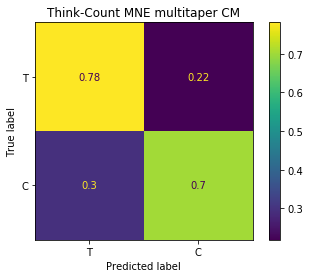

In [24]:
##Confusion matrix
target_names = ['T','C']
fig,ax = plt.subplots()
ax.set_title('Think-Count MNE multitaper CM')
plot_confusion_matrix(clf99,x_99_test,y_test,labels=target_names,ax=ax,normalize='true')
plt.savefig("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/Think-Count_0.1s_CM.png")

In [3]:
# Import raw datasets
#.csv path
# csvpath = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/thinking-counting-switching.csv"
csvpath = "/home/wubuntu/Downloads/thinking-counting-switching.csv"
#Read .csv files
cols_to_use = list(range(4, 36))

#Raw dataframes - each channel is a column
raw_df = pd.read_csv(csvpath, header=None, usecols=cols_to_use)


In [5]:
#Split into thinking and counting data frames
think_index_list = []
count_index_list = []

for i in range(6):
    if i%2==0:
        think_index_list+=(list(range(1280*i,1280*(i+1))))
    else:
        count_index_list+=(list(range(1280*i,1280*(i+1))))

think_bands_list = []
count_bands_list = []

df = raw_df.iloc[0:1280*6]
df_list = np.vsplit(df,6)
think_df = pd.DataFrame(np.vstack((df_list[0],df_list[2],df_list[4])))
think_bands_list.append(think_df)
count_df = pd.DataFrame(np.vstack((df_list[1],df_list[3],df_list[5])))
count_bands_list.append(count_df)

print(think_bands_list[0].shape)
print(count_bands_list[0].shape)

(3840, 32)
(3840, 32)


In [6]:
#Splits a single dataframe into list of equally sized arrays
#Each element in list is nx32 array, where n= sample length 
def split_df(df,fs,sample_t,check=False):
    rows,_ = df.shape #get no. of rows
    sample_len = int(sample_t*fs) #find no. of recorded samples required for each sample time length
    Ns = int(rows/sample_len) #find total no. of samples
    df_cut = df.iloc[:Ns*sample_len] #truncate dataframe to exact multiple of sample length
    # print(Ns*sample_len)
    # print(Ns)
    df_split_list = np.vsplit(df_cut,Ns) #split dataframe row-wise, returns a list
    
    if check:
        print("Total no. of recorded samples: "+str(rows))
        print("Sample length: "+str(sample_len))
        print("Total no. of samples: "+str(Ns))
        print("Length of df_split_list: "+str(len(df_split_list)))
        
        if all(isinstance(x.shape,tuple) for x in df_split_list):
            print("Shape of each element in df_split_list: "+str(df_split_list[0].shape))
        else:
            print("Shapes are wrong.")
            for x in df_split_list:
                print(x.shape)
    return df_split_list,Ns
#Apply split_df() function to list of dataframes, reshape dataframe such that each element is an array 
#for the appropriate sample time length 
def split_bands_list(bands_list,fs,sample_t,check=False,checkSD=False):
    df_list_rFE = [0]*len(bands_list) #dataframes list ready for feature extraction 
    for df_no in range(len(bands_list)):
        df_split_list,Ns = split_df(bands_list[df_no],fs,sample_t,check=checkSD)
        list_of_series = [0]*Ns
        for i in range(len(df_split_list)):
            #New dataframe will have shape Nsx32, each element is a 1xsample_len array 
            new_row = [0]*32 
            #Each df_split_list[i] is a dataframe
            for j in range(len(df_split_list[i].columns)):
                new_row[j] = df_split_list[i].iloc[:,j].values 
            list_of_series[i] = new_row
        df_list_rFE[df_no] = pd.DataFrame(list_of_series)
    if check:
        print("Length of bands_list: "+str(len(bands_list)))
        print("Length of df_list_rFE: "+str(len(df_list_rFE)))
        if (all(isinstance(x.shape,tuple) for x in df_list_rFE)) and (Ns==len(df_list_rFE[0].index)):
            print("Shape of each dataframe in df_list_rFE: "+str(df_list_rFE[0].shape))
    return df_list_rFE

In [7]:
#Split filtered dataframes into samples
fs = 128 #sampling freq
sample_t_list = [0.05,0.1] #sample time lengths in seconds

In [8]:
T_005_splits_df = split_bands_list([think_df],fs,sample_t_list[0],check=False,checkSD=True)[0]
T_01_splits_df  = split_bands_list([think_df],fs,sample_t_list[1],check=False,checkSD=True)[0]

Total no. of recorded samples: 3840
Sample length: 6
Total no. of samples: 640
Length of df_split_list: 640
Shape of each element in df_split_list: (6, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)


In [9]:
C_005_splits_df = split_bands_list([count_df],fs,sample_t_list[0],check=False,checkSD=True)[0]
C_01_splits_df  = split_bands_list([count_df],fs,sample_t_list[1],check=False,checkSD=True)[0]

Total no. of recorded samples: 3840
Sample length: 6
Total no. of samples: 640
Length of df_split_list: 640
Shape of each element in df_split_list: (6, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)


In [10]:
#Save datasets
T_005_splits_df.to_pickle("/media/wubuntu/My Passport/EEG-data/think-count/splits/0.05s/raw_think.pkl")
T_01_splits_df.to_pickle("/media/wubuntu/My Passport/EEG-data/think-count/splits/0.1s/raw_think.pkl")

C_005_splits_df.to_pickle("/media/wubuntu/My Passport/EEG-data/think-count/splits/0.05s/raw_count.pkl")
C_01_splits_df.to_pickle("/media/wubuntu/My Passport/EEG-data/think-count/splits/0.1s/raw_count.pkl")

In [27]:
print(T_01_splits_df.shape)
print(C_01_splits_df.shape)
print("---")
print(T_01_splits_df.iloc[0,0])

(320, 32)
(320, 32)
---
[26.553326 26.526772 26.500244 26.473745 26.447271 26.420824 26.394403
 26.368008 26.34164  26.315298 25.776163 26.263206]


In [83]:
for i in range(32):
    a = T_01_splits_df.iloc[4,i]
    b= psd_array_multitaper(a,128,verbose=0)
    print(b[0])

[0.01435482 0.02824206 0.02636454 0.01985896 0.01330364 0.00125866
 0.00050317]
[25.09127478 48.08759371 40.92564736 34.00396228 36.21082443 32.49307299
 12.78283892]
[ 62.39807525 124.96414495 127.06324073 122.10720219 123.16612105
 153.7770899   90.38990067]
[27.26636265 48.66129203 41.09999397 30.89932972 30.62468017 24.4016493
  7.94822826]
[16.90593915 31.51680314 30.04731312 16.52338887 16.64201626 10.09784157
  2.25962223]
[ 87.53661625 160.20539819 147.2840823   99.79404099  93.29127665
  48.78050395  34.55254413]
[ 93.41731759 182.48501014 165.6843832  127.83222285 122.79729678
  90.18344062  73.63503985]
[ 82.7844271  167.25213557 146.31863052 142.68054742 144.86089888
 181.19889161  91.87367713]
[107.45783267 174.15442819 139.93351714 124.80534041 122.17771086
 121.40731168  68.80431242]
[306.3964899  533.54553142 477.66225227 475.08194494 483.0558242
 782.13671013 435.14779936]
[326.10415727 491.39709938 390.55885404 337.87251369 329.86640972
 276.47451026 242.68150314]
[ 8

In [14]:
T_psd_full = psd_multitaper(T_01_splits_df)
C_psd_full = psd_multitaper(C_01_splits_df) 

In [65]:
print(T_psd_full.shape)
print(C_psd_full.shape)
print(T_psd_full.isnull().values.any())
print(C_psd_full.isnull().values.any())

(320, 32)
(320, 32)
False
False


In [97]:
def expand_df(df):
    df_list = [0]*32
    for i in range(32):
        df_list[i] = pd.DataFrame(df[i].tolist()).fillna(0)
    e_df = pd.concat(df_list,axis=1)
    return e_df

In [98]:
T_e_psd_full = expand_df(T_psd_full)
C_e_psd_full = expand_df(C_psd_full)

In [99]:
print(T_e_psd_full.isnull().values.any())
print(C_e_psd_full.isnull().values.any())
print(T_psd_full.shape)
print(T_e_psd_full.shape)
print(C_psd_full.shape)
print(C_e_psd_full.shape)

False
False
(320, 32)
(320, 224)
(320, 32)
(320, 224)


In [100]:
X = np.vstack((T_e_psd_full,C_e_psd_full))
y = np.hstack((np.array(['T']*T_e_psd_full.shape[0]),
               np.array(['C']*C_e_psd_full.shape[0]),
               ))

In [101]:
#Feature scaling 
sc = StandardScaler()
X = sc.fit_transform(X)
print(X.shape)
print(y.shape)

(640, 224)
(640,)


In [102]:
#Save datasets 
np.save("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/featureScaled/X-full-features",X,allow_pickle=True)
np.save("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/featureScaled/y-full-labels",y,allow_pickle=True)

In [103]:
#Split into training and test sets
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]

#Fit transform on training data
pca99 = PCA(n_components=0.999, svd_solver='full')
x_99_train = pca99.fit_transform(X_train)
#Fit transform on test data
x_99_test = pca99.transform(X_test)
#Gridsearch
C_range = [1,3,10,30,100,300]
param_grid= [
            # {'C': C_range, 'kernel': ['linear']},
            {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
            ]
scoring = {'accuracy','f1_macro'}
clf = svm.SVC()
grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=10,refit='f1_macro')
grid99 = grid.fit(x_99_train,y_train)
#Best Params
best_params99 = grid99.best_params_
clf99 = svm.SVC(**best_params99)
clf99.fit(x_99_train,y_train)
y_99_pred = clf99.predict(x_99_test)
f1Score_full = f1_score(y_test,y_99_pred,average="macro")
#Confusion matrix
cm_full = confusion_matrix(y_test,y_99_pred,normalize='true')

In [104]:
print(f1Score_full)

0.6089931573802541


In [105]:
print(cm_full)

[[0.640625 0.359375]
 [0.421875 0.578125]]


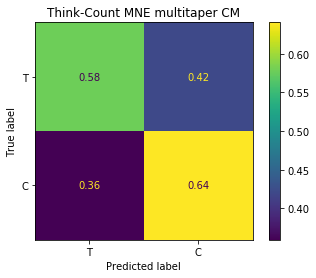

In [106]:
##Confusion matrix
target_names = ['T','C']
fig,ax = plt.subplots()
ax.set_title('Think-Count MNE multitaper CM')
plot_confusion_matrix(clf99,x_99_test,y_test,labels=target_names,ax=ax,normalize='true')
plt.savefig("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/Think-Count_full_0.1s_CM.png")